# Virtual Screening

## Importing modules and functions        
    

In [1]:
import bz2
import glob
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import _pickle as cPickle
import sys

sys.path.append('../')

from cheminformatics import calc_dist_matrix, calc_D_cutoff, calc_test_distances, binary_stats
from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Path for files

In [2]:
# Give name to prediction set
prediction_set = input()

dispiro


In [3]:
# SDF file to screen
sdf_file = 'datasets/dispiro.sdf'

# Models
models = [f for f in glob.glob("models/*.pgz")]
models_data = [f for f in glob.glob("models/*.pbz2")]

# Export predictions
export_predictions= f'vs/{prediction_set}.xlsx'

In [4]:
models

['models\\dataset-01B-hepatic-stability-15-min-binary-balanced-morgan_RF.pgz',
 'models\\dataset-01D-hepatic-stability-60-min-binary-balanced-morgan_RF.pgz',
 'models\\dataset-02A-microsomal-half-life-subcellular-30-min-binary-unbalanced-morgan_RF.pgz',
 'models\\dataset-02B-microsomal-half-life-30-min-binary-unbalanced-morgan_RF.pgz',
 'models\\dataset-03-renal-clearance-binary-unbalanced-0.5-threshold-morgan_RF.pgz',
 'models\\dataset-04B-BBB-binary-balanced-morgan_RF.pgz',
 'models\\dataset-04B-BBB-binary-unbalanced-morgan_RF.pgz',
 'models\\dataset-04C-CNS-binary-unbalanced-morgan_RF.pgz',
 'models\\dataset-05A-CACO2-binary-unbalanced-morgan_RF.pgz',
 'models\\dataset-06-plasma-protein-binding-binary-unbalanced-morgan_RF.pgz',
 'models\\dataset-09-microsomal-clearance-binary-unbalanced-morgan_RF.pgz']

## Import screening data

Original data:  (1, 3)
Kept data:  (1, 2)


,SMILES,Mol
0,Cc1nc(N2CC[N+]3(CC2)CC[N+]2(CCNCC2)CC3)c([N+](...,

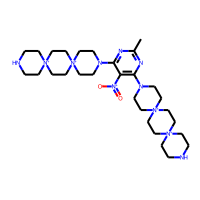


 Problematic structures: 
 []


In [5]:
# Read SDF
moldf = PandasTools.LoadSDF(sdf_file, molColName='Mol', smilesName='SMILES');
print('Original data: ', moldf.shape)

# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')

moldf.drop(columns='ID', inplace=True)
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)
from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

### Calculate Morgan Fingerprints

In [6]:
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

X_vs = moldf.Mol.apply(calcfp)
X_vs.shape

(1, 2048)

# Virtual screening Morgan

##### Load the model and model parameters

In [7]:
predictions = pd.DataFrame()
for model_endpoint, model_data in zip(models, models_data):
    with gzip.open(model_endpoint, 'rb') as f:
        model = cPickle.load(f)
        
    with bz2.BZ2File(model_data, 'rb') as f:
        model_data = cPickle.load(f)  
    
    X_train = model_data['Descriptors']
    D_cutoff = model_data['D_cutoff']
    del model_data

    ##### Predict molecules
    
    conf_threshold = 0.6
    
    #### Make predictions
    y_pred = model.predict(X_vs)
    pred_prob = model.predict_proba(X_vs)
    pred_prob = np.amax(pred_prob, axis=1).round(2)
    
    #### Estimate AD
    pred_dist = calc_test_distances(X_vs, X_train)
    pred_ad = []
    for i in np.arange(0, len(pred_dist), 1):
        if pred_dist[i] < D_cutoff:
            pred_ad.append('Inside')
        else:
            pred_ad.append('Outside')
    
    #### Prepare data
    pred = pd.DataFrame({'Prediction': y_pred, 'Confidence': pred_prob, 'AD': pred_ad})
    # AD
    pred.AD[pred.AD == 'Outside'] = np.nan
    pred.AD[pred.AD == 'Inside'] = pred.Prediction
    pred.sort_index(inplace=True)
    pred_ad = pred.dropna().astype(int)
    coverage_pred = len(pred_ad) / len(pred) * 100
    
    model_endpoint = re.sub('models\\\dataset-\d\d\w*-|-binary-\w*balanced-morgan_RF.pgz', '', model_endpoint)
    model_endpoint = re.sub('-', ' ', model_endpoint)
    pred = pred.assign(model=f'{model_endpoint}')
    
    mol_pred = pd.concat([moldf, pred], axis=1)  
    predictions = predictions.append(mol_pred)

## Export SDF and Excel

In [8]:
with pd.ExcelWriter(export_predictions) as writer:
    predictions.drop(columns='Mol').to_excel(writer, sheet_name='pred-pk', index=False)